# 4. HPO

In [1]:
# Load usefull libraries and helper functions
%run libs_and_utils

seed =  42
libraries loaded


In [2]:
# Load data
df_train = pd.read_csv(r'input/creditcard_train.csv')
df_train.sort_values(by=['Time'], inplace=True)
df_test = pd.read_csv(r'input/creditcard_test.csv')
df_test.sort_values(by=['Time'], inplace=True)

X_train = df_train.drop(columns='Class')
y_train = df_train.Class
X_test = df_test.drop(columns='Class')
y_test = df_test.Class
print('data_loaded')

data_loaded


## Hyperparameter Optimisation
### - LGBM

LGBMClassifier model training...


C:\Users\evgen\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\evgen\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Optimized parameters:     ['num_leaves', 'reg_lambda', 'max_depth', 'min_data_in_leaf', 'max_bin', 'learning_rate']
Previous best parameters: None
Current  best parameters: [130, 31.902619695224484, 52, 106, 1135, 0.7544693634434985]
Best score: 0.8689303109407065


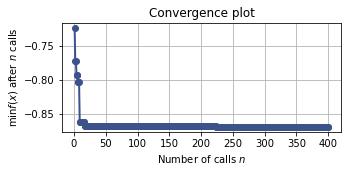

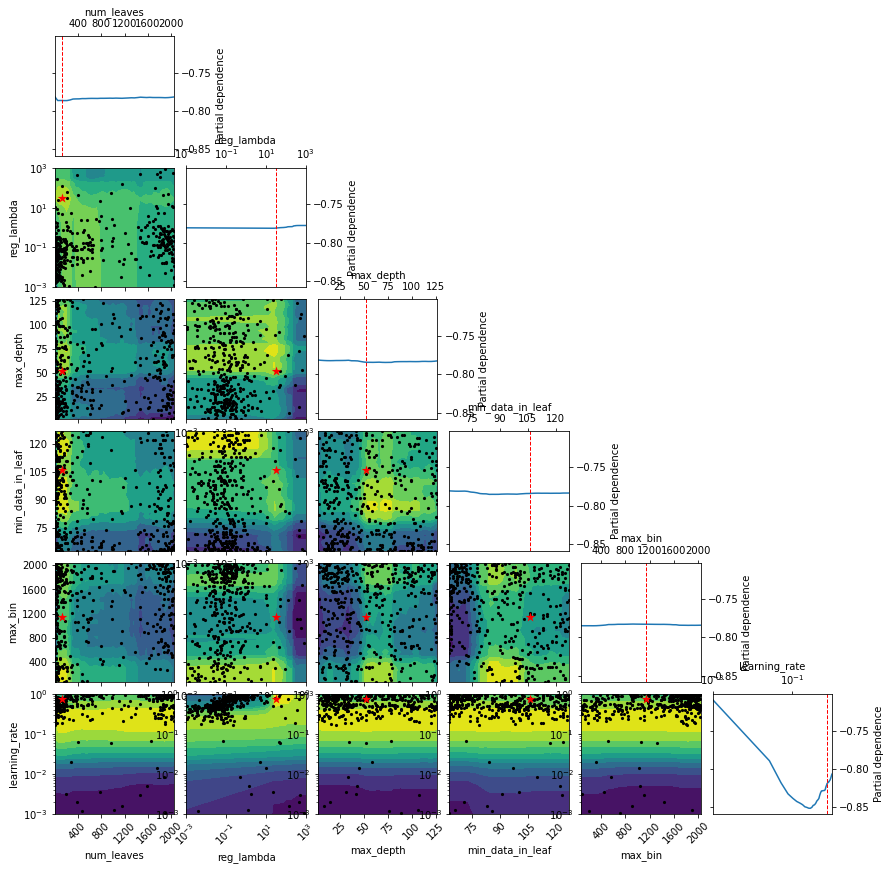

Wall time: 1h 27min 48s


In [57]:
%%time

model_params = {'class_weight': 'balanced', 'num_threads': -1, 'learning_rate': 0.1}

model = LGBMClassifier(**model_params)

dynamic_params_space  = [Integer(7, 2047, name='num_leaves'),
                         Real(1e-3, 1e3, prior='log-uniform', name='reg_lambda'), #L2 reg
                         Integer(2, 127, name='max_depth'),
                         Integer(63, 127, name='min_data_in_leaf'),
                         Integer(63, 2047, name='max_bin'),
                         Real(1e-3, 1, prior='log-uniform', name='learning_rate'),
                         #Real(1e-3, 1, prior='log-uniform', name='alpha_over') 
                        ]

HPO_params = {'n_calls': 400, 'n_random_starts': 20, 'random_state': 42}

find_best_hyperparameters(model,  X_train, y_train, dynamic_params_space, scoring = auprc_score, plot = True, nfold=5, **HPO_params)

In [58]:
model = load_best_parameters(model)
print(model)

LGBMClassifier optimized parameters: {'num_leaves': 130, 'reg_lambda': 31.902619695224484, 'max_depth': 52, 'min_data_in_leaf': 106, 'max_bin': 1135, 'learning_rate': 0.7544693634434985}
LGBMClassifier(class_weight='balanced', learning_rate=0.7544693634434985,
               max_bin=1135, max_depth=52, min_data_in_leaf=106, num_leaves=130,
               num_threads=-1, reg_lambda=31.902619695224484)


Training LGBMClassifier ...
[LightGBM] [Warning] min_data_in_leaf is set=106, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=106
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1


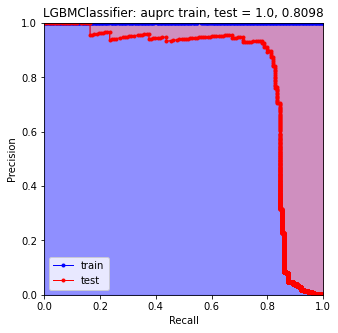

In [59]:
plot_auprc(model, X_train, y_train, X_test, y_test)

## Hyperparameter Optimisation with Under/Oversampling
### - LGBM

### Undersampling
- Undersampling is required for the mainly for speeding up the calculations.
- Random inavitably undersampling causes loss of data.
- Clever undersampling techniques exist in addition to random undersampling https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html. What they do is - they implement some clever algorithm to remove some samples, which might help the model, however I prefer to give the task of finding best separation between the classes to the model itself. It should probably be helpfull with less complex algorithms like LogReg.
- Undersampling can work here as ensembling technique because 

LGBMClassifier model training...


C:\Users\evgen\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\evgen\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\evgen\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\evgen\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the execut

['num_leaves', 'reg_lambda', 'max_depth', 'min_data_in_leaf', 'max_bin', 'learning_rate', 'alpha_over', 'k_neighbors']
Optimized parameters:     ['num_leaves', 'reg_lambda', 'max_depth', 'min_data_in_leaf', 'max_bin', 'learning_rate', 'alpha_over', 'k_neighbors']
Previous best parameters: None
Current  best parameters: [201, 0.012129760266884554, 99, 240, 998, 0.49918600758221426, 0.1416240088814153, 9]
Best score: 0.8719835325871903


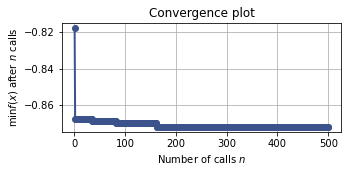

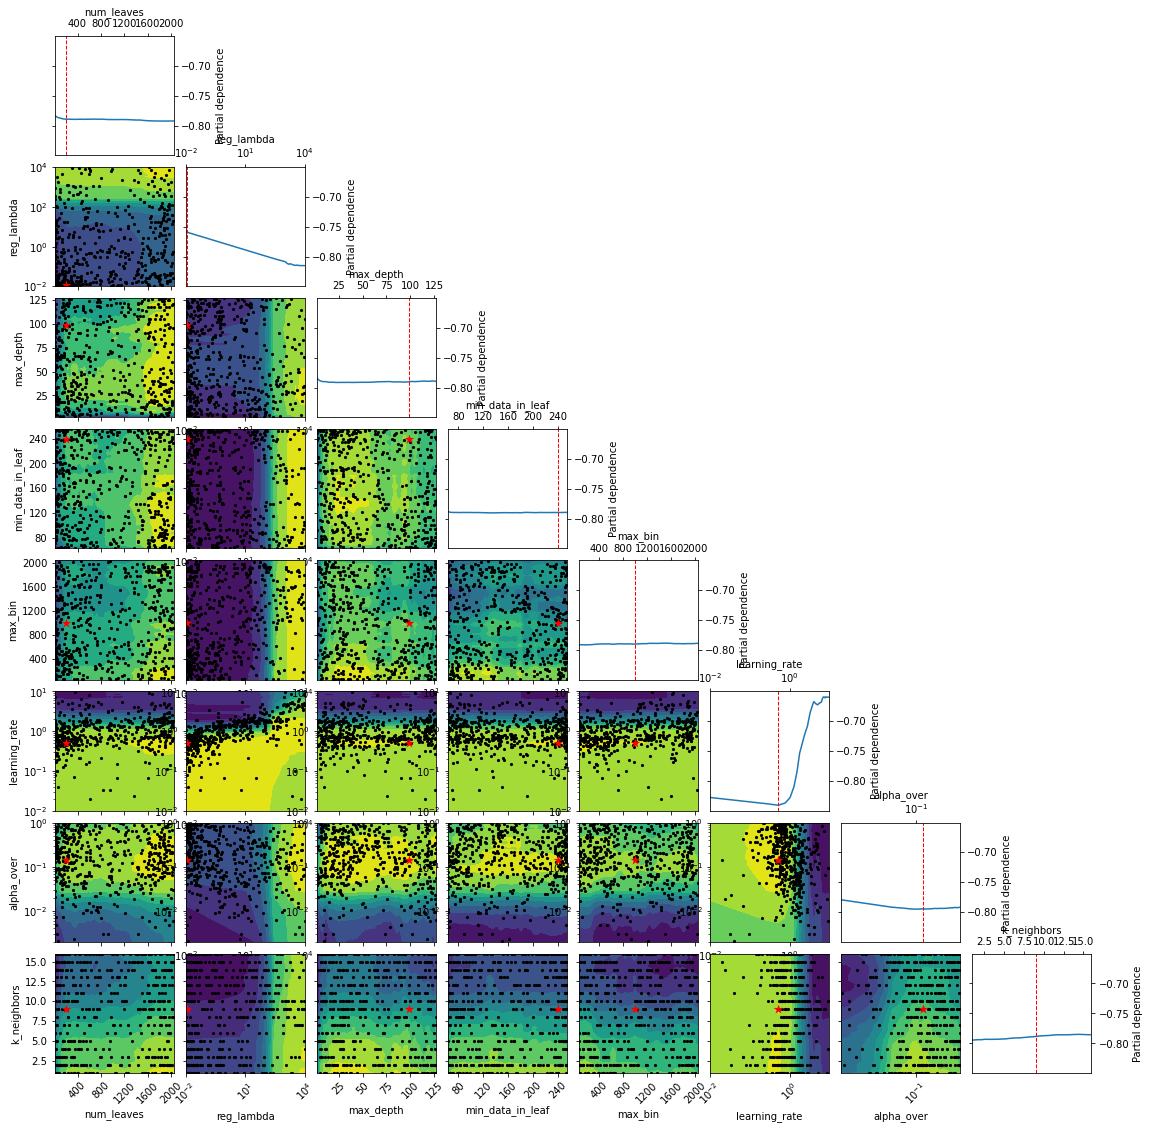

Wall time: 4h 50min 53s


In [9]:
%%time

model_params = {
    'class_weight':  'balanced',
    'num_threads':   -1,
    'random_state':  seed
               }

model = LGBMClassifier(**model_params)

dynamic_params_space  = [
    Integer(7, 2047, name='num_leaves'),
    Real(1e-2, 1e4, prior='log-uniform', name='reg_lambda'), #L2 reg
    Integer(2, 127, name='max_depth'),
    Integer(63, 255, name='min_data_in_leaf'),
    Integer(63, 2047, name='max_bin'),
    Real(1e-1, 10, prior='log-uniform', name='learning_rate'),
                         
    # resampling parameters
    Real(2e-3, 1, prior='log-uniform', name='alpha_over'),
    Integer(2, 10, name='k_neighbors'),
                        ]

HPO_params = {
    'n_calls': 500,
    'n_random_starts': 25,
    'random_state': seed
             }

find_best_hyperparameters_sampling(model,  X_train, y_train, dynamic_params_space, scoring = auprc_score, plot = True, nfold=10, **HPO_params)

In [10]:
model, alpha_over, k_neighbors = load_best_parameters_sampling(model)
#print(model)
print(alpha_over, k_neighbors)

LGBMClassifier optimized parameters: {'num_leaves': 201, 'reg_lambda': 0.012129760266884554, 'max_depth': 99, 'min_data_in_leaf': 240, 'max_bin': 998, 'learning_rate': 0.49918600758221426}
0.1416240088814153 9


In [11]:
print(X_train.shape, y_train.shape, sum(y_train==1))

over = SMOTE(random_state=42, sampling_strategy=alpha_over, k_neighbors=k_neighbors)
X_train_res, y_train_res = over.fit_resample(X_train, y_train)

print(X_train_res.shape, y_train_res.shape, sum(y_train_res==1))

(199364, 30) (199364,) 364
(227183, 30) (227183,) 28183


Training LGBMClassifier ...
[LightGBM] [Warning] min_data_in_leaf is set=240, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=240
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1


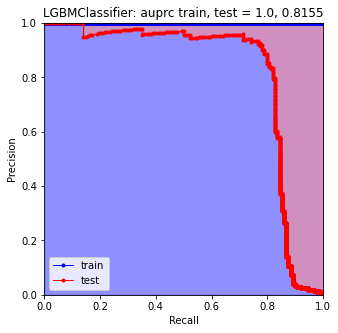

In [12]:
plot_auprc(model, X_train_res, y_train_res, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=240, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=240
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1


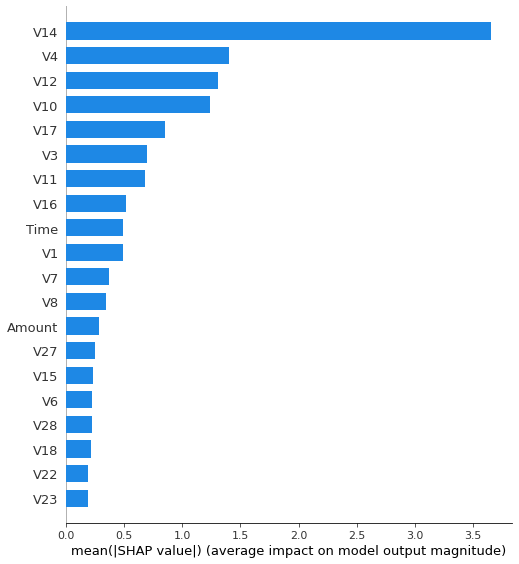

In [13]:
plot_shap_feature_importance(model, X_train_res, y_train_res)

LGBMClassifier model training...
['num_leaves', 'reg_lambda', 'reg_alpha', 'max_depth', 'min_data_in_leaf', 'max_bin', 'learning_rate', 'alpha_over', 'k_neighbors']
Optimized parameters:     ['num_leaves', 'reg_lambda', 'reg_alpha', 'max_depth', 'min_data_in_leaf', 'max_bin', 'learning_rate', 'alpha_over', 'k_neighbors']
Previous best parameters: [885, 30.63462210622084, 1.1756010900231848, 125, 250, 442, 0.35644979070394633, 0.012608496454072608, 2]
Current  best parameters: [618, 0.2008734705666495, 0.24515892466388628, 86, 381, 1076, 0.43704503206629275, 0.004180498819250385, 1]
Best score: 0.8706290426781734


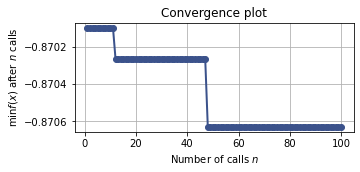

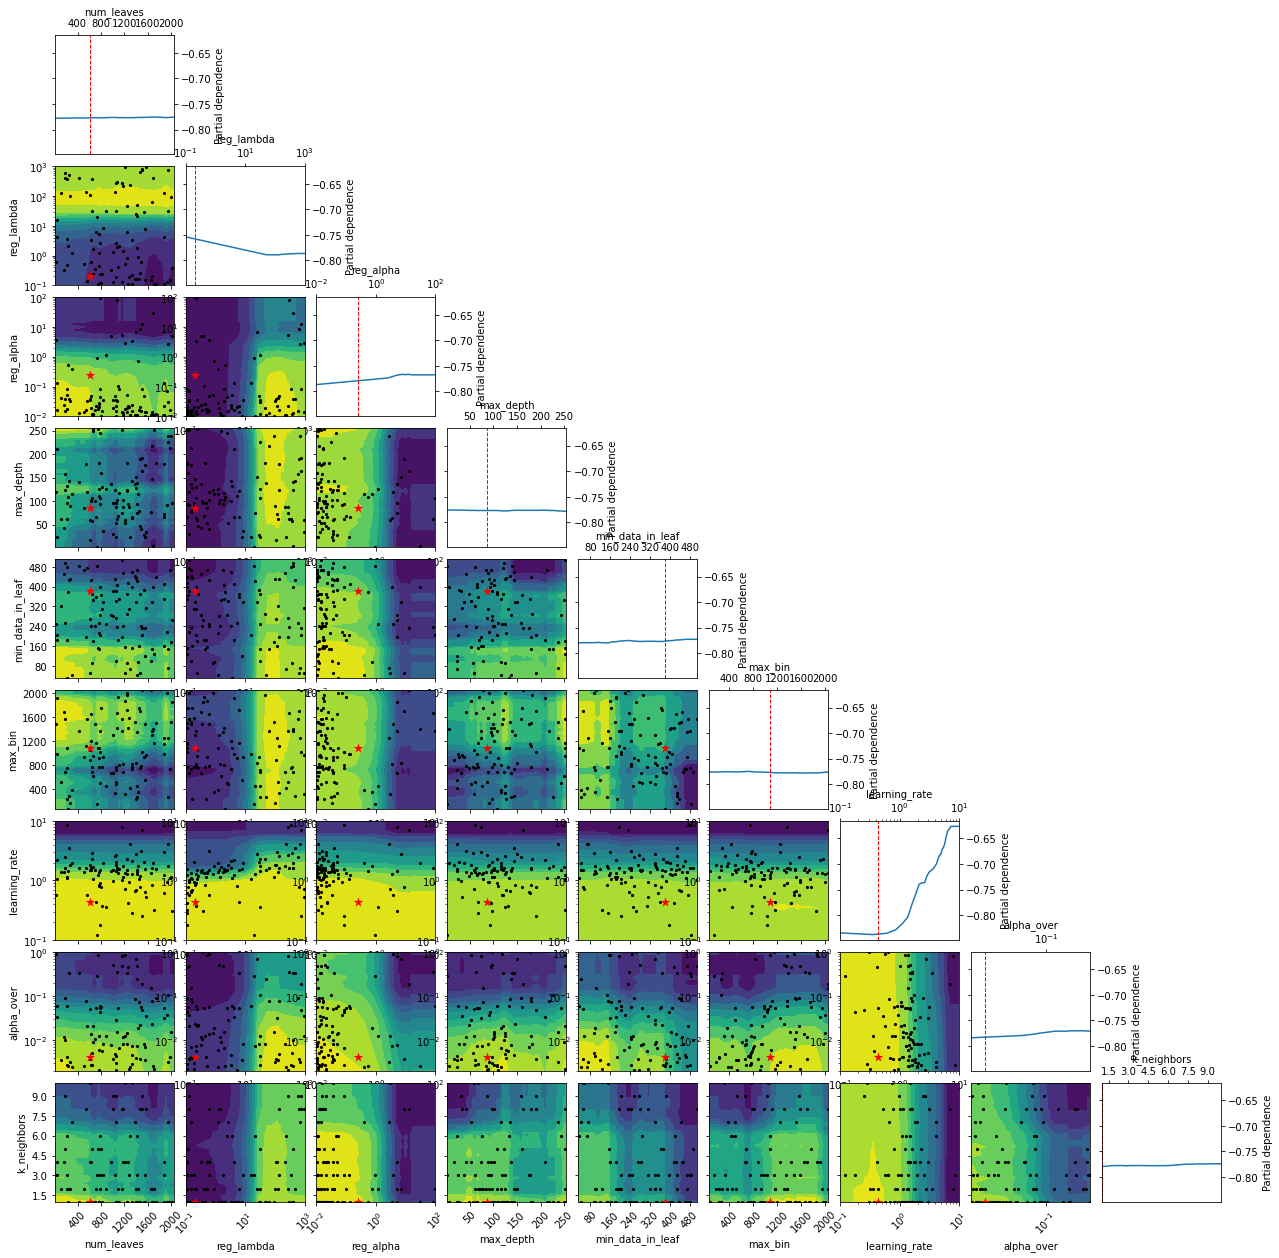

Wall time: 32min 14s


In [24]:
%%time

model_params = {
    'class_weight':  'balanced',
    'num_threads':   -1,
    'random_state':  seed
               }

model = LGBMClassifier(**model_params)

dynamic_params_space  = [
    Integer(7, 2047, name='num_leaves'),
    Real(1e-1, 1e3, prior='log-uniform', name='reg_lambda'), #L2 reg
    Real(1e-2, 1e2, prior='log-uniform', name='reg_alpha'),
    Integer(2, 255, name='max_depth'),
    Integer(31, 511, name='min_data_in_leaf'),
    Integer(63, 2047, name='max_bin'),
    Real(1e-1, 10, prior='log-uniform', name='learning_rate'),
                         
    # resampling parameters
    Real(2e-3, 1, prior='log-uniform', name='alpha_over'),
    Integer(1, 10, name='k_neighbors'),
                        ]

HPO_params = {
    'n_calls': 100,
    'n_random_starts': 10,
    'random_state': seed
             }

find_best_hyperparameters_sampling(model,  X_train, y_train, dynamic_params_space, scoring = auprc_score, plot = True, nfold=5, **HPO_params)

In [25]:
model, alpha_over, k_neighbors = load_best_parameters_sampling(model)
#print(model)
print(alpha_over, k_neighbors)

LGBMClassifier optimized parameters: {'num_leaves': 618, 'reg_lambda': 0.2008734705666495, 'reg_alpha': 0.24515892466388628, 'max_depth': 86, 'min_data_in_leaf': 381, 'max_bin': 1076, 'learning_rate': 0.43704503206629275}
0.004180498819250385 1


In [26]:
print(X_train.shape, y_train.shape, sum(y_train==1))

over = SMOTE(random_state=42, sampling_strategy=alpha_over, k_neighbors=k_neighbors)
X_train_res, y_train_res = over.fit_resample(X_train, y_train)

print(X_train_res.shape, y_train_res.shape, sum(y_train_res==1))

(199364, 30) (199364,) 364
(199831, 30) (199831,) 831


Training LGBMClassifier ...
[LightGBM] [Warning] min_data_in_leaf is set=381, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=381
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1


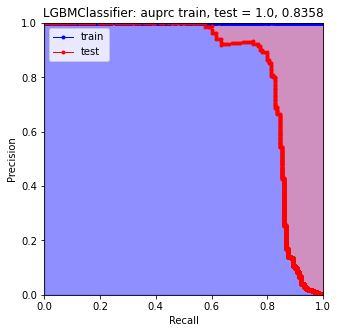

In [27]:
plot_auprc(model, X_train_res, y_train_res, X_test, y_test)

[LightGBM] [Warning] min_data_in_leaf is set=381, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=381
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1


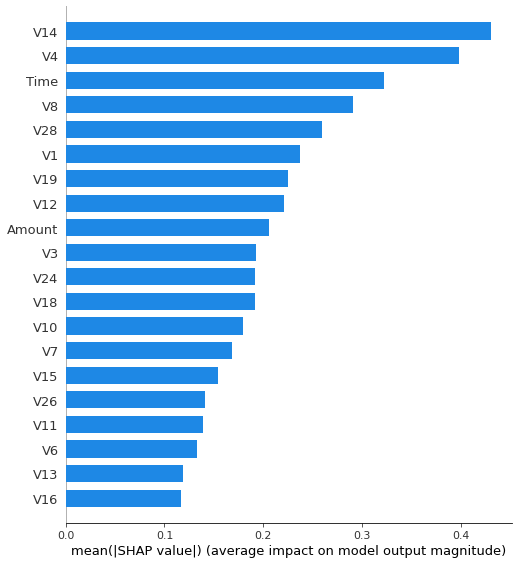

In [28]:
plot_shap_feature_importance(model, X_train_res, y_train_res)

### - ExtraTrees

ExtraTreesClassifier model training...
['n_estimators', 'max_depth', 'criterion', 'min_samples_split', 'max_features', 'alpha_over', 'k_neighbors']
Optimized parameters:     ['n_estimators', 'max_depth', 'criterion', 'min_samples_split', 'max_features', 'alpha_over', 'k_neighbors']
Previous best parameters: None
Current  best parameters: [649, 26, 'entropy', 10, 24, 0.14941422526346582, 5]
Best score: 0.8719740945783926


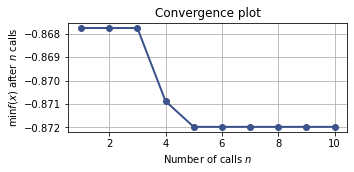

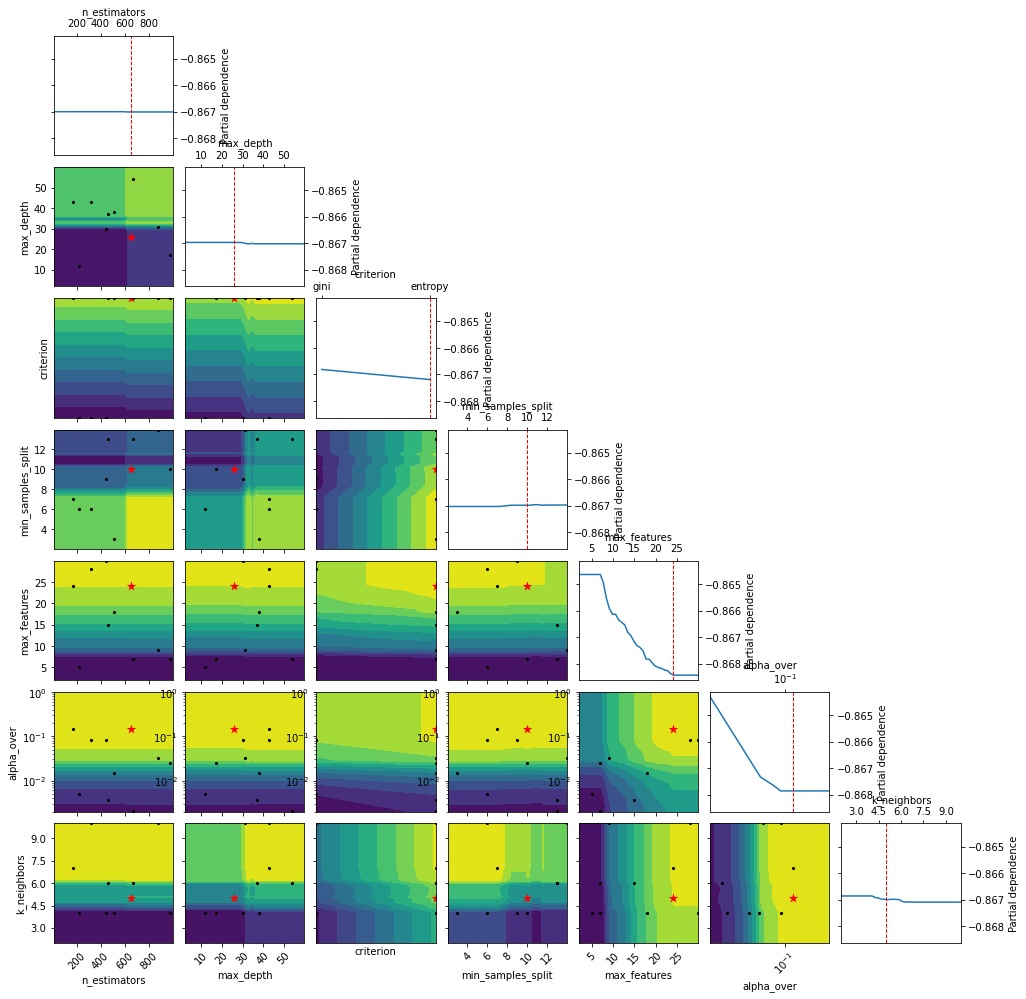

Wall time: 1h 36min 48s


In [8]:
%%time

model_params = {
    'class_weight':  'balanced',
    'n_jobs':   -1,
    'random_state':  seed
               }
model = ExtraTreesClassifier(**model_params)

dynamic_params_space  = [
    Integer(10,1000, name='n_estimators'),
    Integer(2,60, name='max_depth'),    
    Categorical(['gini', 'entropy'], name = 'criterion'),
    Integer(2,14, name='min_samples_split'),
    Integer(2,30, name='max_features'),
                         
    # resampling parameters
    Real(2e-3, 1, prior='log-uniform', name='alpha_over'),
    Integer(2, 10, name='k_neighbors'),
                        ]

HPO_params = {
    'n_calls': 10,
    'n_random_starts': 3,
    'random_state': seed
             }

find_best_hyperparameters_sampling(model,  X_train, y_train, dynamic_params_space, scoring = auprc_score, plot = True, nfold=5, **HPO_params)

In [9]:
model, alpha_over, k_neighbors = load_best_parameters_sampling(model)
#print(model)
print(alpha_over, k_neighbors)

ExtraTreesClassifier optimized parameters: {'n_estimators': 649, 'max_depth': 26, 'criterion': 'entropy', 'min_samples_split': 10, 'max_features': 24}
0.14941422526346582 5


In [10]:
print(X_train.shape, y_train.shape, sum(y_train==1))

over = SMOTE(random_state=42, sampling_strategy=alpha_over, k_neighbors=k_neighbors)
X_train_res, y_train_res = over.fit_resample(X_train, y_train)

print(X_train_res.shape, y_train_res.shape, sum(y_train_res==1))

(199364, 30) (199364,) 364
(228733, 30) (228733,) 29733


Training ExtraTreesClassifier ...


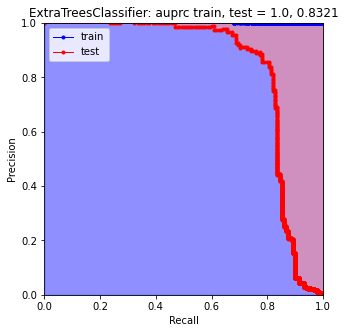

In [11]:
plot_auprc(model, X_train_res, y_train_res, X_test, y_test)

### - RandomForest

RandomForestClassifier model training...
['n_estimators', 'max_depth', 'min_samples_split', 'max_features', 'alpha_over', 'k_neighbors']
Optimized parameters:     ['n_estimators', 'max_depth', 'min_samples_split', 'max_features', 'alpha_over', 'k_neighbors']
Previous best parameters: None
Current  best parameters: [131, 22, 4, 2, 0.06865714527853939, 8]
Best score: 0.8564323354792154


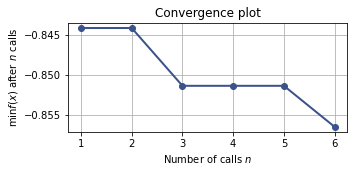

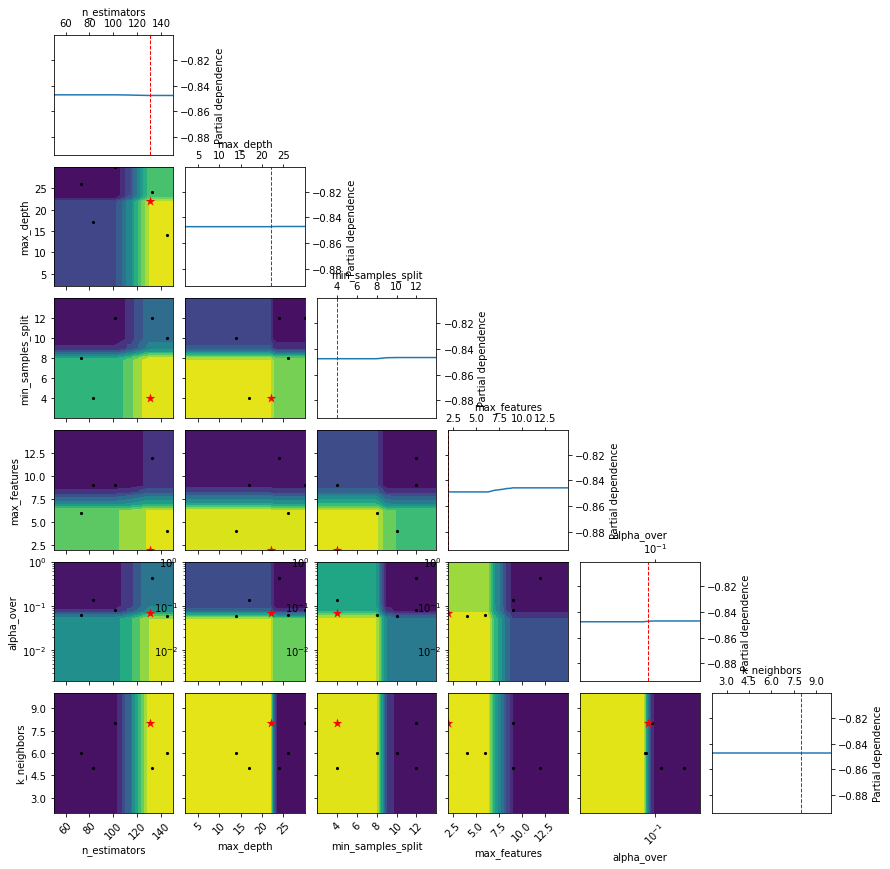

Wall time: 14min 57s


In [3]:
%%time

model_params = {
    'class_weight':  'balanced',
    'n_jobs':   -1,
    'random_state':  seed
               }
model = RandomForestClassifier(**model_params)

dynamic_params_space  = [
    Integer(50,150, name='n_estimators'),
    Integer(2,30, name='max_depth'),    
    Integer(2,14, name='min_samples_split'),
    Integer(2,15, name='max_features'),
                         
    # resampling parameters
    Real(2e-3, 1, prior='log-uniform', name='alpha_over'),
    Integer(2, 10, name='k_neighbors'),
                        ]

HPO_params = {
    'n_calls': 6,
    'n_random_starts': 2,
    'random_state': seed
             }

find_best_hyperparameters_sampling(model,  X_train, y_train, dynamic_params_space, scoring = auprc_score, plot = True, nfold=3, **HPO_params)

In [4]:
model, alpha_over, k_neighbors = load_best_parameters_sampling(model)
#print(model)
print(alpha_over, k_neighbors)

RandomForestClassifier optimized parameters: {'n_estimators': 131, 'max_depth': 22, 'min_samples_split': 4, 'max_features': 2}
0.06865714527853939 8


In [5]:
print(X_train.shape, y_train.shape, sum(y_train==1))

over = SMOTE(random_state=42, sampling_strategy=alpha_over, k_neighbors=k_neighbors)
X_train_res, y_train_res = over.fit_resample(X_train, y_train)

print(X_train_res.shape, y_train_res.shape, sum(y_train_res==1))

(199364, 30) (199364,) 364
(212662, 30) (212662,) 13662


Training RandomForestClassifier ...


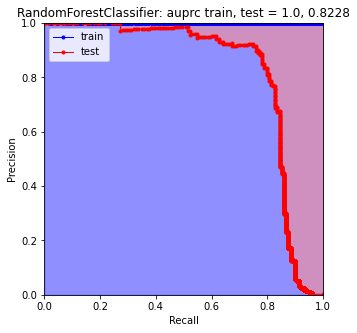

In [6]:
plot_auprc(model, X_train_res, y_train_res, X_test, y_test)